# Notebook examples for Chapter 4

In [1]:
import warnings
# these are innocuous but irritating
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")
%matplotlib inline

### The Convolution Theorem

In [ ]:
%matplotlib inline
import numpy as np
from numpy import fft
from osgeo import gdal
from osgeo.gdalconst import GA_ReadOnly
import matplotlib.pyplot as plt

# get an image band
gdal.AllRegister()
infile = 'imagery/AST_20070501'                 
inDataset = gdal.Open(infile,GA_ReadOnly)     
cols = inDataset.RasterXSize
rows = inDataset.RasterYSize    

# pick out the middle row of pixels
band = inDataset.GetRasterBand(3)  
G = band.ReadAsArray(0,rows/2,cols,1).flatten()

# define a FIR kernel of length m = 5
h = np.array([1 ,2 ,3 ,2 ,1])

# convolve in the spatial domain
Gs = np.convolve(h,G)

# pad the arrays to c + m - 1
G = np.concatenate((G,[0,0,0,0]))
hp = G*0
hp[0:5] = h

# convolve in the frequency domain
Gf = fft.ifft ( fft.fft ( G )* fft.fft ( hp ) ) - 500

x = np.array(range(1004))
plt.plot(x,Gs,x,Gf)

 #plt.savefig('/home/mort/LaTeX/new projects/CRC4/Chapter4/fig4_1.eps')

### Radar ranging

In [ ]:
def chirp(t,t0):
    result = 0.0*t
    idx = np.array(range(2000))+t0 
    tt = t[idx] - t0
    result[idx] = np.sin(2*np.pi*2e-3*(tt+1e-3*tt**2))
    return result
 
t = np.array(range(5000))
plt.plot(t,chirp(t,400)+9)
plt.plot(t,chirp(t,800)+6)
plt.plot(t,chirp(t,1400)+3)
signal = chirp(t,400)+chirp(t,800)+chirp(t,1400)
kernel = chirp(t,0)[:2000]
kernel = kernel[::-1]
plt.plot(t,signal)
plt.plot(0.003*np.convolve(signal,kernel,\
                                 mode='same')-5)
plt.xlabel('Time')
plt.ylim((-8,12))

#plt.savefig('/home/mort/LaTeX/new projects/CRC4/Chapter4/fig4_2.eps')

### Linear filters

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import auxil.auxil1 as auxil

# load the 4th band from LANDSAT 7 ETM+ image
infile = 'imagery/LE7_20010626'
inDataset = gdal.Open(infile,GA_ReadOnly)     
cols = inDataset.RasterXSize
rows = inDataset.RasterYSize 
band = inDataset.GetRasterBand(4)
G = band.ReadAsArray(0,0,cols,rows)

# Fourier transform
Gf = fft.fft2(G)
      
# create a Gaussian filter in frequency space
sigma = 50
Hf = auxil.gaussfilter(sigma,1000,1000)

# low- and high-pass filtering in frequency domain
Gl = np.real(fft.ifft2(Gf*Hf))
Gh = np.real(fft.ifft2(Gf*(1.-Hf)))

# plot the filter
fig = plt.figure()
ax = fig.gca(projection='3d') 
x, y = np.meshgrid(range(rows),range(cols))
ax.plot_surface(x, y, np.roll(Hf,(rows/2,cols/2),(0,1)),
                             cmap=cm.coolwarm)

#plt.savefig('/home/mort/LaTeX/new projects/CRC4/Chapter4/fig4_3.eps',bbox_inches='tight')

In [ ]:
# save and plot the filtered bands
import gdal
from osgeo.gdalconst import GDT_Float32
driver = gdal.GetDriverByName('Gtiff')   
outDataset = driver.Create('imagery/Gh.tif',
                cols,rows,2,GDT_Float32)        
outBand = outDataset.GetRasterBand(1)
outBand.WriteArray(Gl,0,0)
outBand = outDataset.GetRasterBand(2)
outBand.WriteArray(Gh,0,0)
outBand.FlushCache() 
outDataset = None    

In [ ]:
run scripts/dispms -f 'imagery/Gh.tif' -p [1,1,1] -e 3 \
#-s '/home/mort/LaTeX/new projects/CRC4/Chapter4/fig4_4.eps'

In [ ]:
run scripts/dispms -f 'imagery/Gh.tif' -p [2,2,2] -e 3 \
#-s '/home/mort/LaTeX/new projects/CRC4/Chapter4/fig4_5.eps'

### Wavelets and filter banks

In [ ]:
from auxil.auxil1 import DWTArray

# instantiate a DWTArray object
dwtarr = DWTArray(G,1000,1000)
data0 = np.copy(dwtarr.data)

# filter once
dwtarr.filter()
data1 = np.copy(dwtarr.data)
quad1 = np.abs(dwtarr.get_quadrant(1))

# filter again
dwtarr.filter()
data2 = dwtarr.data

# plot
f, ax = plt.subplots(2,2,figsize=(8,8))
ax[0,0].imshow(data0,cmap=cm.gray) 
ax[0,0].set_title('(a)')
ax[0,1].imshow(data1,cmap=cm.gray) 
ax[0,1].set_title('(b)')
ax[1,0].imshow(data2,cmap=cm.gray)  
ax[1,0].set_title('(c)')
ax[1,1].imshow(np.log(quad1-np.min(quad1)+1e-6),
                     cmap=cm.gray)
ax[1,1].set_title('(d)')

#plt.savefig('/home/mort/LaTeX/new projects/CRC4/Chapter4/fig4_11.eps',bbox_inches='tight')

### Kernel PCA

In [ ]:
run scripts/kpca -h

       kPCA
infile:  imagery/LE7_20010626
samples: 0
kernel:  Gaussian
running k-means on 100 cluster centers...
centered kernel matrix...
gamma: 2.795051304463428e-06
diagonalizing...
projecting...
result written to: imagery/LE7_20010626_kpca
elapsed time: 40.1919689178


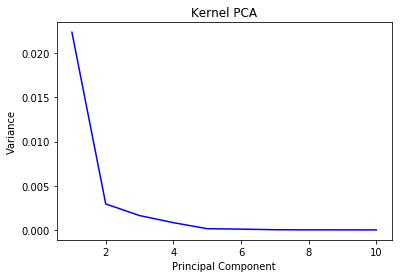

--done------------------------


In [2]:
run scripts/kpca -s 0 imagery/LE7_20010626

In [ ]:
run scripts/dispms -f imagery/LE7_20010626_kpca -p [1,2,3] -e 3 \
#-s '/home/mort/LaTeX/new projects/CRC4/Chapter4/fig4_13.eps'